In [1]:
"""
Run baselines of LSTM and CNN models
"""
import sys
from pathlib import Path

# Add the parent directory of this script to sys.path
parent_dir = Path.cwd().parent
sys.path.append(str(parent_dir))

# Now you can import modules from the parent directory
import torch
from helpers.simulation import *
from helpers.models import *
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim.lr_scheduler import CosineAnnealingLR

In [2]:
def train(model, N: int, T: int, props: dict, image_props: dict, device: torch.device, cycles: int, losses: list, vlosses: list):
    """
    Training loop

    Args:
        model:
            Model to train
        N: int
            Number of particles to simulate
        T: int
            Number of timesteps in a simulation
        props: dict
            Parameters of the model
        image_props: dict
            Parameters for imaging simulation
        device: torch.device
            Device to put data on
        cycles: int
            Number of cycles of training to go through
        losses: list
            List to keep track of training losses
        vlosses: list
            List to keep track of validation losses
    """
    # Define optimizer and scheduler
    optimizer = torch.optim.AdamW(model.parameters(), props['lr'], weight_decay=props.get('weight_decay', 0.001))
    scheduler = CosineAnnealingLR(optimizer, T_max=cycles, eta_min=1e-5)

    model.to(device)

    # Get validation data
    val_data = np.load('../data/validation_data.npz')
    val_videos = torch.Tensor(val_data['vids'])
    val_labels = torch.Tensor(val_data['labels'])
    D_max_normalization = image_props['D_max_norm']
    val_labels = val_labels / torch.Tensor([D_max_normalization, D_max_normalization, 1])

    val_dataset = VideoDataset(val_videos, val_labels)
    val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False)
    
    # Create training data
    all_videos, all_labels = create_training_set(N, T, image_props)

    # Normalize labels for better optimization
    all_labels = all_labels / np.array([D_max_normalization, D_max_normalization, 1])
    
    # Convert to tensors
    all_labels = torch.Tensor(all_labels)
    all_videos = torch.Tensor(all_videos)

    # Create dataset and dataloader objects
    dataset = VideoDataset(all_videos, all_labels)
    dataloader = DataLoader(dataset, batch_size=props['batch_size'], shuffle=True)

    # Training
    for epoch in tqdm(range(cycles), desc='Epochs of training'):
        model.train()

        batch_loss = []
        # Train
        for videos, _, labels in dataloader:
            videos = videos.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            output = model(videos)

            loss = props['loss_fn'](labels, output)

            batch_loss.append(loss.item())
            loss.backward()
            optimizer.step()
        
        scheduler.step()

        losses.append(np.mean(batch_loss))

        # Validation
        model.eval()
        with torch.no_grad():
            batch_vloss = []
            for videos, _, labels in val_dataloader:
                labels = labels.to(device)                
                videos = videos.to(device)
                
                val_predictions = model(videos)

                l = props['loss_fn'](labels, val_predictions)
                batch_vloss.append(l.item())
            vlosses.append(np.mean(batch_vloss))

        print(f"Epoch {epoch+1}/{cycles} | Train Loss: {losses[-1]:.4f} | Val Loss: {vlosses[-1]:.4f}")

Using device: cuda
Total params of LSTM: 545060


Epochs of training:   3%|▎         | 1/30 [00:37<18:02, 37.34s/it]

Epoch 1/30 | Train Loss: 1.3641 | Val Loss: 1.2178


Epochs of training:   7%|▋         | 2/30 [01:14<17:27, 37.40s/it]

Epoch 2/30 | Train Loss: 1.0074 | Val Loss: 1.3185


Epochs of training:  10%|█         | 3/30 [01:51<16:45, 37.23s/it]

Epoch 3/30 | Train Loss: 0.9542 | Val Loss: 1.2167


Epochs of training:  13%|█▎        | 4/30 [02:29<16:13, 37.43s/it]

Epoch 4/30 | Train Loss: 0.9412 | Val Loss: 0.9624


Epochs of training:  17%|█▋        | 5/30 [03:05<15:23, 36.94s/it]

Epoch 5/30 | Train Loss: 0.9303 | Val Loss: 1.2375


Epochs of training:  20%|██        | 6/30 [03:42<14:43, 36.80s/it]

Epoch 6/30 | Train Loss: 0.9157 | Val Loss: 1.1242


Epochs of training:  23%|██▎       | 7/30 [04:19<14:08, 36.89s/it]

Epoch 7/30 | Train Loss: 0.9008 | Val Loss: 0.8617


Epochs of training:  27%|██▋       | 8/30 [04:57<13:39, 37.27s/it]

Epoch 8/30 | Train Loss: 0.8996 | Val Loss: 0.9469


Epochs of training:  30%|███       | 9/30 [05:34<13:04, 37.37s/it]

Epoch 9/30 | Train Loss: 0.8874 | Val Loss: 1.1732


Epochs of training:  33%|███▎      | 10/30 [06:11<12:23, 37.18s/it]

Epoch 10/30 | Train Loss: 0.8848 | Val Loss: 0.8654


Epochs of training:  37%|███▋      | 11/30 [06:50<11:57, 37.78s/it]

Epoch 11/30 | Train Loss: 0.8830 | Val Loss: 0.8629


Epochs of training:  40%|████      | 12/30 [07:30<11:30, 38.36s/it]

Epoch 12/30 | Train Loss: 0.8978 | Val Loss: 1.2639


Epochs of training:  43%|████▎     | 13/30 [08:08<10:52, 38.37s/it]

Epoch 13/30 | Train Loss: 0.8677 | Val Loss: 1.1025


Epochs of training:  47%|████▋     | 14/30 [08:48<10:18, 38.63s/it]

Epoch 14/30 | Train Loss: 0.8701 | Val Loss: 0.8129


Epochs of training:  50%|█████     | 15/30 [09:25<09:35, 38.37s/it]

Epoch 15/30 | Train Loss: 0.8611 | Val Loss: 0.9594


Epochs of training:  53%|█████▎    | 16/30 [10:04<08:57, 38.38s/it]

Epoch 16/30 | Train Loss: 0.8601 | Val Loss: 0.9945


Epochs of training:  57%|█████▋    | 17/30 [10:45<08:29, 39.16s/it]

Epoch 17/30 | Train Loss: 0.8549 | Val Loss: 0.8753


Epochs of training:  60%|██████    | 18/30 [11:25<07:55, 39.64s/it]

Epoch 18/30 | Train Loss: 0.8509 | Val Loss: 0.7962


Epochs of training:  63%|██████▎   | 19/30 [12:05<07:14, 39.54s/it]

Epoch 19/30 | Train Loss: 0.8524 | Val Loss: 0.8647


Epochs of training:  67%|██████▋   | 20/30 [12:45<06:38, 39.84s/it]

Epoch 20/30 | Train Loss: 0.8486 | Val Loss: 0.9055


Epochs of training:  70%|███████   | 21/30 [13:26<06:00, 40.03s/it]

Epoch 21/30 | Train Loss: 0.8471 | Val Loss: 0.8083


Epochs of training:  73%|███████▎  | 22/30 [14:05<05:18, 39.85s/it]

Epoch 22/30 | Train Loss: 0.8445 | Val Loss: 0.7909


Epochs of training:  77%|███████▋  | 23/30 [14:45<04:39, 39.89s/it]

Epoch 23/30 | Train Loss: 0.8376 | Val Loss: 0.7843


Epochs of training:  80%|████████  | 24/30 [15:23<03:56, 39.40s/it]

Epoch 24/30 | Train Loss: 0.8352 | Val Loss: 0.8936


Epochs of training:  83%|████████▎ | 25/30 [16:02<03:16, 39.28s/it]

Epoch 25/30 | Train Loss: 0.8351 | Val Loss: 0.8052


Epochs of training:  87%|████████▋ | 26/30 [16:44<02:39, 39.81s/it]

Epoch 26/30 | Train Loss: 0.8316 | Val Loss: 0.8198


Epochs of training:  90%|█████████ | 27/30 [17:24<02:00, 40.11s/it]

Epoch 27/30 | Train Loss: 0.8311 | Val Loss: 0.7920


Epochs of training:  93%|█████████▎| 28/30 [18:04<01:20, 40.01s/it]

Epoch 28/30 | Train Loss: 0.8271 | Val Loss: 0.7931


Epochs of training:  97%|█████████▋| 29/30 [18:45<00:40, 40.40s/it]

Epoch 29/30 | Train Loss: 0.8281 | Val Loss: 0.7941


Epochs of training: 100%|██████████| 30/30 [19:27<00:00, 38.90s/it]

Epoch 30/30 | Train Loss: 0.8261 | Val Loss: 0.7753


validation_data
Average loss across validation set: 0.7751379536187395
Average RMSE of diffusion coefficients and angle simularity across validation set: [1.0740561  0.86995083 0.87539494]
--------------------------------------------------
validation_data_small_diffusion
Average loss across validation set: 0.9704906496595829
Average RMSE of diffusion coefficients and angle simularity across validation set: [0.96041024 0.626272   0.83849585]
--------------------------------------------------
validation_data_no_noise
Average loss across validation set: 2.474347971855326
Average RMSE of diffusion coefficients and angle simularity across validation set: [6.025727 4.170426 0.650142]
--------------------------------------------------
validation_data_large_diffusion
Average loss across validation set: 0.6461615048824473
Average RMSE of diffusion coefficients and angle simularity across validation set: [1.1386993  1.0544417  0.89550537]
--------------------------------------------------
valida

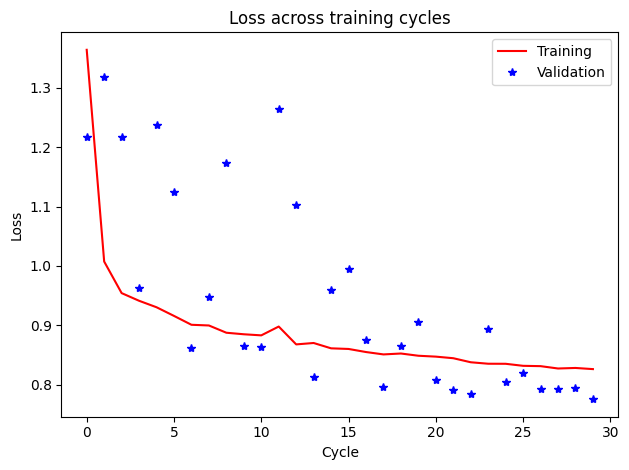

In [7]:
# Define model parameters
model_props= {
    "lr": 1e-4,
    "embed_dim": 64,
    "num_heads": 4,
    "hidden_dim": 128,
    "num_layers": 2,
    "dropout": 0.01,
    "batch_size": 16,
    "loss_fn": mse_loss,
    "weight_decay": 0.01,
    "model": LSTM
}

if model_props['loss_fn'] is mse_loss_coeff:
    output_size = 2
else: 
    output_size = 4

# Image parameters
N = 60000 # number of particles to simulate
nPosPerFrame = 10 
nFrames = 30
T = nFrames * nPosPerFrame
# values from Real data
background_mean,background_sigma = 1420, 290
part_mean, part_std = 6000 - background_mean,500

image_props = {
    "n_pos_per_frame": nPosPerFrame,
    "frames": nFrames,
    "particle_intensity": [
        part_mean,
        part_std,
    ],  # Mean and standard deviation of the particle intensity
    "NA": 1.46,  # Numerical aperture
    "wavelength": 500e-9,  # Wavelength
    "psf_division_factor": 1.3,  
    "resolution": 100e-9,  # Camera resolution or effective resolution, aka pixelsize
    "output_size": 9,
    "upsampling_factor": 5,
    "background_intensity": [
        background_mean,
        background_sigma,
    ],  # Standard deviation of background intensity within a video
    "poisson_noise": 100, #  -1 for no noise,
    "gaussian_noise": True,
    "trajectory_unit" : 1200,
    "D_min": 1, # >= 1
    "D_max": 10,
    "angle_max": np.pi,
    "D_max_norm": 10, # factor to divide by for normalization
}

# Number of cycles of generating training data and training
cycles = 30
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

np.random.seed(150)

# Keep track of loss across training for plotting
losses = []
vlosses = []

# Train model
if model_props['model'] is LSTM:
    model = LSTM(model_props['embed_dim'], model_props['hidden_dim'], 
            model_props['num_layers'], output_size, bidirectional=False, dropout=model_props['dropout'])
else:
    model = Pix2D(output_dim=output_size)

print(f"Total params of {model.__class__.__name__}: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")
train(model, N, T, model_props, image_props, device, cycles, losses, vlosses)

# Evaluation
model.eval()
for file in [f for f in os.listdir('../data') if f.startswith('validation_data')]:
    # Get validation data
    data = np.load('../data/' + file)
    videos = torch.Tensor(data['vids'])
    displacements = torch.Tensor(data['disp'])
    labels = torch.Tensor(data['labels'])
    
    D_max_normalization = image_props['D_max_norm']
    labels = labels / torch.Tensor([D_max_normalization, D_max_normalization, 1])

    # Create dataset and dataloader
    dataset = VideoDataset(videos, labels)
    dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

    with torch.no_grad():
        loss = []
        errors = []
        for videos, _, labels in dataloader:
            videos = videos.to(device)
            labels = labels.to(device)
            
            val_predictions = model(videos)

            val_loss = model_props['loss_fn'](labels, val_predictions)
            loss.append(val_loss.item()) # batch loss

            angle_pred = 0.5 * torch.atan2(val_predictions[:,2], val_predictions[:,3])
            if model_props['loss_fn'] is mse_loss or mse_loss_coeff:
                mse = torch.stack([
                    (val_predictions[:,0] - labels[:,0])**2, 
                    (val_predictions[:,1] - labels[:,1])**2,
                ], axis=1).mean(axis=0)
            else:
                mse = torch.stack([
                    (torch.exp(val_predictions[:,0]) - labels[:,0])**2, 
                    (torch.exp(val_predictions[:,1]) - labels[:,1])**2,
                ], axis=1).mean(axis=0)
            rmse_batch = torch.sqrt(mse)
            angle_sim = torch.abs(torch.cos(angle_pred - labels[:,-1])).mean().unsqueeze(-1)
            errors.append(torch.cat([
                    rmse_batch.cpu() * D_max_normalization,
                    angle_sim.cpu()
                ], axis=0))

        # Compute average across all labels
        avg_loss = np.mean(loss)
        avg_rmse = np.mean(errors, axis=0)
        print(file[:-4])
        print(f"Average loss across validation set: {avg_loss}")
        print(f"Average RMSE of diffusion coefficients and angle simularity across validation set: {avg_rmse}")
        print(50*'-')

# Plot loss over time during training
fig, ax = plt.subplots()
ax.plot(losses, 'r', label='Training')
ax.plot(vlosses, 'b*', label='Validation')
ax.set_title('Loss across training cycles')
ax.set_ylabel('Loss')
ax.set_xlabel('Cycle')
ax.legend()
fig.tight_layout()
plt.show()

## MSD Baseline

In [2]:
import numpy as np
from helpers.helpersMSD import *

np.random.seed(1)

# Image parameters
N = 5000 # number of particles to simulate
nPosPerFrame = 10 
nFrames = 30
T = nFrames * nPosPerFrame
# values from Real data
background_mean,background_sigma = 1420, 290
part_mean, part_std = 6000 - background_mean,500

image_props = {
    "n_pos_per_frame": nPosPerFrame,
    "frames": nFrames,
    "particle_intensity": [
        part_mean,
        part_std,
    ],  # Mean and standard deviation of the particle intensity
    "NA": 1.46,  # Numerical aperture
    "wavelength": 500e-9,  # Wavelength
    "psf_division_factor": 1.3,  
    "resolution": 100e-9,  # Camera resolution or effective resolution, aka pixelsize
    "output_size": 9,
    "upsampling_factor": 5,
    "background_intensity": [
        background_mean,
        background_sigma,
    ],  # Standard deviation of background intensity within a video
    "poisson_noise": 100,
    "gaussian_noise": True,
    "trajectory_unit" : 1200,
    "D_min": 1,
    "D_max": 10,
    "angle_max": np.pi
}

videos, displacement, labels, centroids, pos = create_training_set_w_features(N, T, image_props)

### Using Exact Position Data

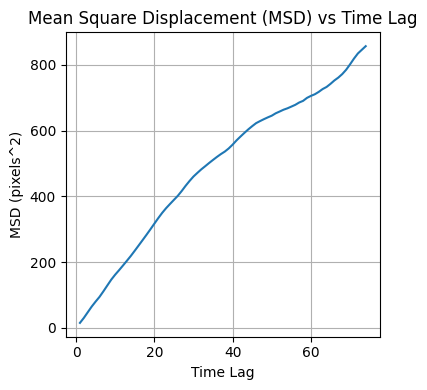

In [3]:
# Compute covariance matrices for each particle and time lags
C, taus = compute_covariance_matrix(pos)

# Estimate diffusion tensor from covariance matrix
D = estimate_diffusion_tensor(C, taus)

# Decompose tensor to get diffusion coeff and angle
vals, angles = diffusion_tensor_decomposition(D)

plotMSD(C, taus)

In [4]:
mse = np.stack([
    (vals[:,0] - labels[:,0])**2, 
    (vals[:,1] - labels[:,1])**2,
    ], axis=1).mean(axis=0)
rmse_batch = np.sqrt(mse)
angle_sim = np.array([np.abs(np.cos(angles - labels[:,-1])).mean()])
errors = np.concatenate((rmse_batch, angle_sim), axis=0)

print(f"Average RMSE of diffusion coefficients and angle simularity across validation set: {errors}")

Average RMSE of diffusion coefficients and angle simularity across validation set: [4.90700415 2.28855099 0.80015214]


### Use centroid positioning

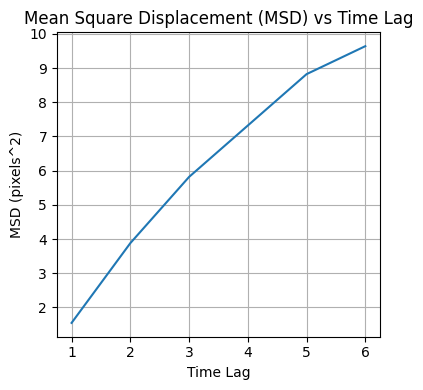

In [5]:
# Undo conversions to get back to units of simulation
#centroids = centroids * 100 / (image_props['trajectory_unit'] / (image_props['resolution'] * 1e9))

# Compute covariance matrices for each particle and time lags
C, taus = compute_covariance_matrix(centroids)

# Estimate diffusion tensor from covariance matrix
D = estimate_diffusion_tensor(C, taus)

# Decompose tensor to get diffusion coeff and angle
vals, angles = diffusion_tensor_decomposition(D)

plotMSD(C, taus)

In [6]:
mse = np.stack([
    (vals[:,0] - labels[:,0])**2, 
    (vals[:,1] - labels[:,1])**2,
    ], axis=1).mean(axis=0)
rmse_batch = np.sqrt(mse)
angle_sim = np.array([np.abs(np.cos(angles - labels[:,-1])).mean()])
errors = np.concatenate((rmse_batch, angle_sim), axis=0)

print(f"Average RMSE of diffusion coefficients and angle simularity across validation set: {errors}")

Average RMSE of diffusion coefficients and angle simularity across validation set: [5.12440442 3.52183528 0.6390692 ]
